In [10]:
import firebase_admin
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from firebase_admin import credentials, firestore
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, f1_score, precision_score, recall_score, cohen_kappa_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Firebase Initialization
cred = credentials.Certificate("adminkey.json")
#firebase_admin.initialize_app(cred)
db = firestore.client()

# Constants
INCLUDE_ONLY = ['10000', '10002','10004','10007','10008','10009']
ACTIVITIES = ['walk', 'stairs']
SAMPLING_RATE = 100
OVERLAP = 0.5
CHUNK_SIZE = 1
BATCH_SIZE = 64
EPOCHS = 100
LEARNING_RATE = 0.001
DIFF_THRESHOLD = 35

In [3]:
def fetch_data_by_treatment(treatment_filter):
    data_raw, docs = [], []
    data_ref = db.collection("data").document(treatment_filter)

    for patient_id in INCLUDE_ONLY:
        subject_ref = data_ref.collection(patient_id)
        for activity in ACTIVITIES:
            activity_ref = subject_ref.document(activity)
            phone_location_col = activity_ref.collections()

            for phone_location in phone_location_col:
                for recording in phone_location.stream():
                    record = recording.to_dict()
                    if 'acceleration' not in record:
                        continue
                    df = pd.DataFrame(record['acceleration'])
                    timestamps = df['timestamp']
                    min_time = timestamps.min()
                    max_time = timestamps.max()
                    df = df[(timestamps >= min_time + 2500) & (timestamps <= max_time - 2500)]
                    if df.empty:
                        continue
                    combined = pd.DataFrame({
                        'ax': df['accelerometer'].apply(lambda x: x['x']),
                        'ay': df['accelerometer'].apply(lambda x: x['y']),
                        'az': df['accelerometer'].apply(lambda x: x['z']),
                        'gx': df['gyroscope'].apply(lambda x: x['x']),
                        'gy': df['gyroscope'].apply(lambda x: x['y']),
                        'gz': df['gyroscope'].apply(lambda x: x['z']),
                    })
                    data_raw.append(combined)
                    docs.append({'activity': activity})
    return data_raw, docs

def chunk_data_raw(data_raw, docs, chunk_size_sec, sampling_rate, overlap=OVERLAP):
    data, labels = [], []
    chunk_samples = int(chunk_size_sec * sampling_rate)
    step = int(chunk_samples * (1 - overlap))
    for i, df in enumerate(data_raw):
        for start in range(0, len(df) - chunk_samples + 1, step):
            chunk = df.iloc[start:start + chunk_samples]
            if len(chunk) == chunk_samples:
                data.append(chunk.values)
                labels.append(ACTIVITIES.index(docs[i]['activity']))
    return np.array(data), np.array(labels)

def get_score(train_acc, test_acc, lambda_penalty=0.2):
    score = test_acc - lambda_penalty * abs(train_acc - test_acc)
    return score

In [4]:
class PositionalEncoding(nn.Module):
    def __init__(self, emb_size, dropout=0.1, maxlen=5000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        pe = torch.zeros(maxlen, emb_size)
        position = torch.arange(0, maxlen, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, emb_size, 2).float() * (-math.log(10000.0) / emb_size))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

class TransformerClassifier(nn.Module):
    def __init__(self, input_dim=6, emb_size=64, nhead=8, nhid=128, nlayers=3, nclasses=len(ACTIVITIES), dropout=0.1):
        super().__init__()
        self.embedding = nn.Sequential(
            nn.Linear(input_dim, emb_size),
            nn.LayerNorm(emb_size)  # LayerNorm
        )
        self.pos_encoder = PositionalEncoding(emb_size, dropout)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=emb_size,
            nhead=nhead,
            dim_feedforward=nhid,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=nlayers)
        self.dropout_fc = nn.Dropout(0.3)  # Dropout before classifier

        # MLP head instead of single linear
        self.classifier = nn.Sequential(
            nn.Linear(emb_size, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, nclasses)
        )
        self.emb_size = emb_size

    def forward(self, x):
        x = self.embedding(x) * math.sqrt(self.emb_size)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        x = self.dropout_fc(x)
        x = self.classifier(x)
        return x

In [17]:
def train_and_evaluate_pre_post():
    # --- Data preparation ---
    before_raw, before_docs = fetch_data_by_treatment('BeforeTreatment')
    X_train_full, y_train_full = chunk_data_raw(before_raw, before_docs, CHUNK_SIZE, SAMPLING_RATE, OVERLAP)
    X_train_np, X_val_np, y_train_np, y_val_np = train_test_split(
        X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full
    )

    after_raw, after_docs = fetch_data_by_treatment('AfterTreatment')
    X_test_np, y_test_np = chunk_data_raw(after_raw, after_docs, CHUNK_SIZE, SAMPLING_RATE, OVERLAP)

    # --- Normalization ---
    scaler = StandardScaler()
    X_train_np = scaler.fit_transform(X_train_np.reshape(-1, 6)).reshape(X_train_np.shape)
    X_val_np   = scaler.transform(X_val_np.reshape(-1, 6)).reshape(X_val_np.shape)
    X_test_np  = scaler.transform(X_test_np.reshape(-1, 6)).reshape(X_test_np.shape)

    # --- Convert to tensors and loaders ---
    X_train = torch.tensor(X_train_np, dtype=torch.float32)
    y_train = torch.tensor(y_train_np, dtype=torch.long)
    X_val   = torch.tensor(X_val_np, dtype=torch.float32)
    y_val   = torch.tensor(y_val_np, dtype=torch.long)
    X_test  = torch.tensor(X_test_np, dtype=torch.float32)
    y_test  = torch.tensor(y_test_np, dtype=torch.long)

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
    val_loader   = DataLoader(TensorDataset(X_val, y_val), batch_size=BATCH_SIZE)
    test_loader  = DataLoader(TensorDataset(X_test, y_test), batch_size=BATCH_SIZE)

    # --- Model setup ---
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = TransformerClassifier().to(device)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

    warmup_epochs = 10
    total_epochs = EPOCHS
    train_acc_history, val_acc_history = [], []

    # --- Training loop ---
    for epoch in range(total_epochs):
        if epoch < warmup_epochs:
            lr_scale = 0.1 + 0.9 * (epoch / warmup_epochs)
        else:
            lr_scale = 0.5 * (1 + math.cos(math.pi * (epoch - warmup_epochs) / (total_epochs - warmup_epochs)))
        for pg in optimizer.param_groups:
            pg['lr'] = LEARNING_RATE * lr_scale

        # Training step
        model.train()
        total_correct, total = 0, 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_correct += (preds.argmax(dim=1) == yb).sum().item()
            total += yb.size(0)
        train_acc = total_correct / total * 100
        train_acc_history.append(train_acc)

        # Validation step
        model.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                val_correct += (preds.argmax(dim=1) == yb).sum().item()
                val_total += yb.size(0)
        val_acc = val_correct / val_total * 100
        val_acc_history.append(val_acc)

        print(f"Epoch {epoch+1}/{total_epochs} | LR: {optimizer.param_groups[0]['lr']:.6f} | "
              f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    # --- Plot training history ---
    plt.figure(figsize=(7,5))
    plt.plot(range(1, total_epochs+1), train_acc_history, label='Train Accuracy', marker='o')
    plt.plot(range(1, total_epochs+1), val_acc_history, label='Validation Accuracy', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy per Epoch')
    plt.ylim(0, 105)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.show()

    # --- Test evaluation ---
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            all_preds.extend(preds.argmax(dim=1).cpu().numpy())
            all_labels.extend(yb.cpu().numpy())

    # --- Metrics ---
    test_acc = (np.array(all_preds) == np.array(all_labels)).mean() * 100
    test_bal_acc = balanced_accuracy_score(all_labels, all_preds) * 100
    test_f1_macro = f1_score(all_labels, all_preds, average='macro') * 100
    test_f1_micro = f1_score(all_labels, all_preds, average='micro') * 100
    test_precision_macro = precision_score(all_labels, all_preds, average='macro') * 100
    test_recall_macro = recall_score(all_labels, all_preds, average='macro') * 100
    test_cohen_kappa = cohen_kappa_score(all_labels, all_preds)

    print(f"\nTest Accuracy: {test_acc:.2f}%")
    print(f"Balanced Accuracy: {test_bal_acc:.2f}%")
    print(f"F1 Score: Macro={test_f1_macro:.2f}% | Micro={test_f1_micro:.2f}%")
    print(f"Precision (Macro): {test_precision_macro:.2f}% | Recall (Macro): {test_recall_macro:.2f}%")
    print(f"Cohen's Kappa: {test_cohen_kappa:.3f}")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=ACTIVITIES))

    # --- Confusion matrix ---
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=ACTIVITIES, yticklabels=ACTIVITIES)
    plt.title('Confusion Matrix: After Treatment')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # --- Threshold check for noticeable change ---
    acc_diff = abs(train_acc_history[-1] - test_acc)
    if acc_diff >= DIFF_THRESHOLD:
        print(f"Train-Test accuracy differs by {acc_diff:.2f}% → noticeable change")
    else:
        print(f"Train-Test accuracy differs by {acc_diff:.2f}% → small change")

    return {
        'train_acc_history': train_acc_history,
        'val_acc_history': val_acc_history,
        'test_acc': test_acc,
        'test_bal_acc': test_bal_acc,
        'test_f1_macro': test_f1_macro,
        'test_f1_micro': test_f1_micro,
        'test_precision_macro': test_precision_macro,
        'test_recall_macro': test_recall_macro,
        'test_cohen_kappa': test_cohen_kappa,
        'all_preds': all_preds,
        'all_labels': all_labels,
        'acc_diff': acc_diff
    }

Epoch 1/100 | LR: 0.000100 | Train Acc: 55.32% | Val Acc: 74.15%
Epoch 2/100 | LR: 0.000190 | Train Acc: 63.19% | Val Acc: 72.88%
Epoch 3/100 | LR: 0.000280 | Train Acc: 69.89% | Val Acc: 82.20%
Epoch 4/100 | LR: 0.000370 | Train Acc: 80.00% | Val Acc: 86.86%
Epoch 5/100 | LR: 0.000460 | Train Acc: 86.91% | Val Acc: 94.07%
Epoch 6/100 | LR: 0.000550 | Train Acc: 91.28% | Val Acc: 95.34%
Epoch 7/100 | LR: 0.000640 | Train Acc: 95.85% | Val Acc: 93.22%
Epoch 8/100 | LR: 0.000730 | Train Acc: 96.38% | Val Acc: 94.07%
Epoch 9/100 | LR: 0.000820 | Train Acc: 96.28% | Val Acc: 94.49%
Epoch 10/100 | LR: 0.000910 | Train Acc: 96.91% | Val Acc: 97.03%
Epoch 11/100 | LR: 0.001000 | Train Acc: 98.09% | Val Acc: 96.61%
Epoch 12/100 | LR: 0.001000 | Train Acc: 97.55% | Val Acc: 96.61%
Epoch 13/100 | LR: 0.000999 | Train Acc: 98.30% | Val Acc: 97.03%
Epoch 14/100 | LR: 0.000997 | Train Acc: 98.83% | Val Acc: 97.03%
Epoch 15/100 | LR: 0.000995 | Train Acc: 98.51% | Val Acc: 97.03%
Epoch 16/100 | LR: 

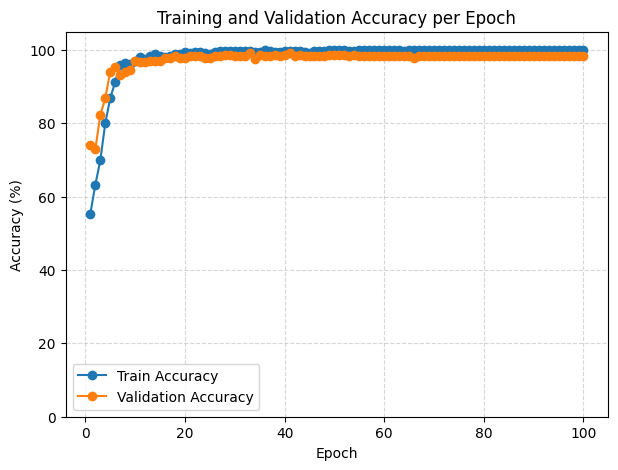


Test Accuracy: 66.11%
Balanced Accuracy: 64.15%
F1 Score: Macro=63.36% | Micro=66.11%
Precision (Macro): 67.74% | Recall (Macro): 64.15%
Cohen's Kappa: 0.293

Classification Report:
              precision    recall  f1-score   support

        walk       0.71      0.43      0.53       735
      stairs       0.64      0.86      0.73       882

    accuracy                           0.66      1617
   macro avg       0.68      0.64      0.63      1617
weighted avg       0.67      0.66      0.64      1617



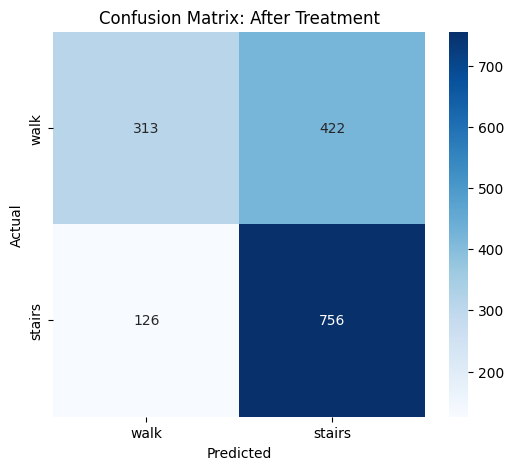

Train-Test accuracy differs by 33.78% → small change


In [18]:
if __name__ == "__main__":
    train_and_evaluate_pre_post()